Import libaries

In [594]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import re
import seaborn as sns
import matplotlib.pyplot as plt

Data loading and preprocessing

In [595]:
def clean_Q2(q2):
    """
    Clean column Q2 in csv file, converting to all numerical discrete values.
    Handles various input formats and extracts numerical information.
    """
    # Handle NaN values
    if pd.isna(q2):
        return pd.NA
    
    # Convert to string and strip whitespace
    q2 = str(q2).strip()
    
    # Handle "I don't know" or similar cases
    if any(phrase in q2.lower() for phrase in ['#name?', 'don\'t know', 'dont know', 'no idea']):
        return pd.NA
    
    # Normalize the string
    q2_lower = q2.lower()
    
    # Spelled out number mapping
    spelled_out_numbers = {
        'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5,
        'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10,
        'eleven': 11, 'twelve': 12
    }
    
    # First, try to extract numbers using regex
    def extract_number(text):
        # Try to find numbers with decimal points or whole numbers
        numbers = re.findall(r'\b(\d+(?:\.\d+)?)\b', text)
        
        # If numbers found, return the first one as an integer
        if numbers:
            return int(float(numbers[0]))
        
        # Check for spelled out numbers
        for word, num in spelled_out_numbers.items():
            if word in text.lower():
                return num
        
        return None
    
    # Check for ranges first (prioritize range parsing)
    range_match = re.search(r'(\d+(?:\.\d+)?)\s*[-~]\s*(\d+(?:\.\d+)?)', q2)
    if range_match:
        low = float(range_match.group(1))
        high = float(range_match.group(2))
        return int((low + high) / 2)
    
    # Textual indicators for approximation
    approx_indicators = ['around', 'about', 'approximately', '~', 'roughly']
    
    # Check for approximation with numbers
    for indicator in approx_indicators:
        if indicator in q2_lower:
            num = extract_number(q2)
            if num is not None:
                return num
    
    # Extract direct number
    direct_num = extract_number(q2)
    if direct_num is not None:
        return direct_num
    
    # Handle ingredient lists
    # Split by common delimiters and count unique ingredients
    delimiters = [',', '\n', ' and ', ';']
    for delimiter in delimiters:
        ingredients = [ing.strip() for ing in q2.split(delimiter) if ing.strip()]
        if len(ingredients) > 1:
            return len(set(ingredients))
    
    # If no number or ingredients are found, print and return NA
    print(f"Could not parse Q2 value: {q2}")
    return pd.NA
# Function to clean Q4
def clean_price(price_str):
    if not price_str: 
        return -1
    
    price_str = str(price_str).strip()
    
    # When it is just a number
    if price_str.isdigit():
        return int(price_str)
    
    # Find all the numbers
    numbers = re.findall(r'\d+\.?\d*', price_str)
    
    if not numbers:
        return -1
    
    if len(numbers) >= 2:
        # finding the median 
        num1 = float(numbers[0])
        num2 = float(numbers[1])
        median = (num1 + num2) / 2
        return round(median)
    
    # whole numbers
    return round(float(numbers[0]))

# Function to clean Q5
def clean_movie_text(text):
    """
    Takes a raw free-text movie string, cleans and maps it to a standard category.
    Returns a string representing a known movie.
    """
    movies = ['1001nights', '11sep', '13hours', '2012', '21jumpstreet', '30minutesorless', '3idiots', '47ronin', '7samurai', '9', 'actionmovie', 'airbud', 'aladdin', 'alien', 'alitathewarrior', 'americanpie', 'anchorman', 'angrybirds', 'anime', 'anjaanaanjaani', 'aquaman', 'aquietplace', 'arcane', 'argo', 'asilentvoice', 'avengers', 'avengers:endgame', 'babylon', 'backinaction', 'backtothefuture', 'badboys', 'bahen', 'barbie', 'batman', 'bighero6', 'billionstvshow', 'blackhawkdown', 'bladerunner', 'bollywood', 'borat', 'breakaway', 'breakingbad', 'bullettrain', 'burnt', 'captainamerica', 'carryon', 'cars', 'casablanca', 'chandnichowktochina', 'chef', 'chinesezodiac', 'cityhunter', 'cleopatra', 'cloudywithachanceofmeatballs', 'coco', 'comedy', 'coraline', 'crayonshinchan', 'crazyrichasians', 'crazystupidlove', 'dabba', 'dangal', 'deadpool', 'deadsilence', 'despicableme', 'detectiveconan', 'diaryofawimpykid', 'dictator', 'diehard', 'djangounchained', 'doraemon', 'dotherightthing', 'dragon', 'drange', 'drishyam', 'drive', 'dune', 'eastsidesushi', 'eatpraylove', 'emojimovie', 'eternalsunshineofthespotlessmind', 'evangelion', 'everythingeverywhereallatonce', 'fallenangels', 'fast&furious', 'fastandfurious', 'ferrisbuellersdayoff', 'fightclub', 'findingnemo', 'fivenightsatfreddys', 'foodwars', 'forrestgump', 'freeguy', 'friday', 'friends', 'frozen', 'futurama', 'garfield', 'gijoe', 'girlstrip', 'gladiator', 'godfather', 'godzilla', 'gonegirl', 'goodfellas', 'goodwillhunting', 'gossipgirl', 'granturismo', 'greenbook', 'grownups', 'haikyu', 'hangover', 'happygilmore', 'haroldandkumar', 'harrypoter', 'harrypotter', 'hawkeye', 'heretic', 'highschoolmusical', 'hitman', 'homealone', 'horror', 'housemd', 'howlsmovingcastle', 'howtoloseaguyin10days', 'hunger', 'idk', 'idontknow', 'inception', 'indianajones', 'insideout', 'interstellar', 'ipman', 'ironman', 'isleofdogs', 'italianjon', 'jamesbond', 'jaws', 'jirodreamsofsush', 'jirodreamsofsushi', 'johnnyenglish', 'johnwick', 'jurassicpark', 'karatekid', 'khabikhushikhabigham', 'kikisdeliveryservice', 'killbill', 'kingdomofheaven', 'kingkong', 'koenokatachi', 'kungfupanda', 'lalaland', 'lastsamurai', 'lawrenceofarabia', 'legendofshawama', 'lifeisbeautiful', 'lifeofpi', 'lionking', 'liquoricepizza', 'lizandthebluebird', 'lordoftherings', 'lostintranslation', 'lovehard', 'luca', 'lucy', 'madagascar', 'madeinabyssdawnofthedeepsoul', 'madmax', 'mammamia', 'mandoob', 'maninblack', 'mariomovie', 'masterchef', 'mazerunner', 'meangirls', 'meitanteikonan', 'memoirsofageisha', 'memoryofageisha', 'meninblack', 'middleeasternmovie', 'middleeasternmovies', 'middleeastmovie', 'midnightdiner', 'midnightdinner', 'minions', 'mission:impossible', 'moneyball', 'monster', 'monsterhouse', 'monsterinc', 'monstersinc', 'montypython', 'mrdeeds', 'mulan', 'murdermystery', 'murderontheorientexpress', 'mycousinvinny', 'myheroacademia', 'myneighbourtotoro', 'mysticpizza', 'na', 'naruto', 'neverendingstory', 'no', 'nosferatu', 'nothing', 'notsure', 'nottinghill', 'oldboy', 'onceuponatimeinhollywood', 'onepiece', 'oppenheimer', 'pacificrim', 'parasite', 'passengers2016', 'pearlharbour', 'piratesofthecaribbean', 'piratesofthecarribeans', 'pizza', 'pizza2012', 'pokemon', 'pokemonthefirstmovie', 'ponyo', 'princeofegypt', 'princessdiaries', 'probablysomemiddleeatmovies', 'probablysomenichemovieorsomemoviespecifictoacountryandnotanenglishmovie', 'probablysomethingwithamiddleeasternsetting', 'pulpfiction', 'pursuitofhappyness', 'ratatouille', 'ratatoullie', 'rattatouieeventhoughthereisntpizza', 'readyplayeronethereispacmaninsideandpizzalookslikeone', 'relaxingcomedy', 'rickandmorty', 'romancemovie', 'romanticmovies', 'runningman', 'rurounikenshin', 'rushhour', 'samuraijack', 'savingprivateryan', 'scarymovie', 'scarymovie42006', 'scifi', 'scoobydoo', 'scottpilgrim', 'setitup', 'sevensamurai', 'shangchi', 'shanghainoon', 'sharktale', 'shawarmalegend', 'shawshankredemption', 'shazam', 'shogun', 'shortmoviebecauseieatitfast', 'shrek', 'slumdogmillionaire', 'snowpiercer', 'someghiblimovie', 'sonicthehedgehog', 'sonofbabylon', 'soul', 'southpark', 'spacejam', 'spiderman', 'spiritedaway', 'spongebob', 'spykids', 'squidgame', 'starwars', 'starwars:thelastjedi', 'stepbrothers', 'strangerthings', 'suits', 'superbad', 'suzume', 'talented', 'taxidriver', 'teenagemutantninjaturtles', 'terminator', 'thebiglebowski', 'thebigshort', 'thebigsick', 'theboyandtheheron', 'theboys', 'thebreakfastclub', 'thedavincicode', 'thedictator', 'thedoramovie', 'thegarfieldmovie', 'thegentlemen', 'thegodfather', 'thegodfatherpartii', 'thegoofymovie', 'thegrinch', 'thehangover', 'thehungergames', 'theintern', 'theinvisibleguest', 'theitalianjob', 'thekiterunner', 'thelastsamurai', 'thelegomovie', 'thelegomovie2', 'thelionking', 'thelittlemermaid', 'themariomovie', 'themeg', 'themenu', 'themummy', 'thepacific', 'theperfectstorm', 'theprinceofegypt', 'theproposal', 'theritual', 'theroadtofallujah', 'theroom', 'thesamurai', 'thesocialnetwork', 'thespynextdoor', 'thetrumanshow', 'thewhale', 'thisistheend', 'thosecommercialsbythetorontofoodmanzabebsiisthebest', 'threeidiots', 'timeofhappiness', 'titanic', 'tokyostory', 'totoro', 'toystory', 'toystory4', 'traintobusan', 'transformer', 'turningred', 'ultramanrising', 'unclegrandpa', 'unknown', 'us', 'venom', 'wags', 'walle', 'waynesworld', 'weatheringwithyou', 'whiplash', 'whoami2005', 'whoamijackiechan', 'wicked', 'wizardsofwaverlyplacemovie', 'wolfofwallstreet', 'wolverine', 'yakuza', 'yehjawaanihaideewani', 'youdontmesswiththezohan', 'yourname', 'zootopia']


    # Handle missing or NaN
    if pd.isna(text):
        return 'unknown'

    # Convert to lowercase + remove punctuation
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r' ', '', text)
    
    #check that text is a recognized move, otherwise label with unknown
    text = next((movie for movie in movies if movie in text), "unknown")

    return text

def one_hot_encode(response_str, categories):
    result = np.zeros(len(categories))
    if isinstance(response_str, str):  # Check if it's a string (not NaN)
        selections = response_str.split(',')
        for i, category in enumerate(categories):
            if category in selections:
                result[i] = 1
    return result

# Function to clean Q6
def clean_drink_text(text):
    """
    Takes a raw free-text drink string, cleans and maps it to a standard category.
    Returns a string representing the drink category (e.g., 'soda', 'coffee', etc.).
    """
    # Handle missing or NaN
    if pd.isna(text):
        return 'unknown'

    # Convert to lowercase + remove punctuation
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)

    # Fix common misspellings & unify certain brand names
    text = re.sub(r'coka\s+cola', 'coca cola', text)
    text = re.sub(r'cocacola', 'coca cola', text)

    # Define brand/keyword tp category mappings
    brand_to_category = {
        # Soda
        'coke': 'soda',
        'coca cola': 'soda',
        'cola': 'soda',
        'pepsi': 'soda',
        'sprite': 'soda',
        'fanta': 'soda',
        'mountain dew': 'soda',
        'dr pepper': 'soda',

        # Asian pop
        "ramune": "asian pop",
        "yakult": "asian pop",

        # Energy drinks
        'red bull': 'energy drink',
        'monster': 'energy drink',

        # Alcohol
        'beer': 'alcohol',
        'wine': 'alcohol',
        'saporo': 'alcohol',

        # asian alcohol
        'sake': 'asian alcohol',
        'soju': 'asian alcohol',

        # Hot drinks
        'coffee': 'coffee',
        'espresso': 'coffee',
        'latte': 'coffee',
        'tea': 'tea',

        # soup ? because that's clearly a drink
        "soup": "soup",

        # Other
        'juice': 'juice',
        'water': 'water',
        'milk': 'milk',
        'smoothie': 'smoothie',
        'milkshake': 'milkshake',
    }

    # Check if multiple categories might apply
    # (e.g. user typed "coffee or tea or water")
    # collect them in a set
    categories_found = set()

    # check each key in the text
    for brand, cat in brand_to_category.items():
        if brand in text:
            categories_found.add(cat)

    # If found no matching categories, label as 'other'
    if not categories_found:
        return 'other'

    # If found multiple, join them with a comma:
    return ', '.join(sorted(categories_found))

def clean_data(df):
    """
    Clean and format the data in the dataframe
    """
    df.rename(columns={'Q1: From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)': 'Q1', 
                       'Q2: How many ingredients would you expect this food item to contain?': 'Q2', 
                       'Q3: In what setting would you expect this food to be served? Please check all that apply': 'Q3',
                       'Q4: How much would you expect to pay for one serving of this food item?': 'Q4',
                       'Q5: What movie do you think of when thinking of this food item?': 'Q5',
                       'Q6: What drink would you pair with this food item?': 'Q6',
                       'Q7: When you think about this food item, who does it remind you of?': 'Q7',
                       'Q8: How much hot sauce would you add to this food item?': 'Q8',
                       }, inplace=True)

    #cleaning Q2
    df['Q2'] = df['Q2'].apply(clean_Q2)
    df['Q2'] = pd.to_numeric(df['Q2'], errors='coerce')

    #Q3 requires no cleaning

    #cleaning Q4 
    df["Q4"] = df["Q4"].apply(clean_price)

    #cleaning Q5
    df["Q5"] = df["Q5"].apply(clean_movie_text)
    #cleaning Q6
    df["Q6"] = df["Q6"].apply(clean_drink_text)

    #Q7 requires no cleaning
    #Q8 requires no cleaning

    # Drop rows with missing values
    df = df.dropna()
    # for col in ["Q3", "Q7", "Q8"]:
    #     df[col] = df[col].fillna("Unknown")
    # for col in ["Q1", "Q2", "Q4"]:
    #     df[col] =  df[col].fillna(-1)


    return df

def encode_data(df):
    # Categorical Feature categories
    Q3_categories = ["Week day lunch", "Week day dinner", "Weekend lunch", "Weekend dinner", "At a party", "Late night snack"]
    
    Q6_categories = [
        "soda", "other", "tea", "alcohol", "water", "soup", "juice", "milk", 
        "unknown", "smoothie", "asian alcohol", "asian pop", "milkshake"
    ]
    Q7_categories = ["Parents", "Siblings", "Friends", "Teachers", "Strangers"]
    Q8_categories = ["None", "A little (mild)", "A moderate amount (medium)", "A lot (hot)", "I will have some of this food item with my hot sauce"]
    
    df_genres = df['Q5'].str.get_dummies(sep=',')

    # Concatenate the new genre columns with the original DataFrame
    df = pd.concat([df, df_genres], axis=1)
    df = df.drop(columns=['Q5'])

    # One hot encode Q3, Q5, Q6, and Q7
    q3 = np.array([one_hot_encode(response, Q3_categories) for response in df['Q3']])
    q6 = np.array([one_hot_encode(response, Q6_categories) for response in df['Q6']])
    q7 = np.array([one_hot_encode(response, Q7_categories) for response in df['Q7']])

    # Create new columns for Q3, Q6, and Q7
    for i, category in enumerate(Q3_categories):
        df[category] = q3[:, i]
    for i, category in enumerate(Q6_categories):
        df[category] = q6[:, i]
    for i, category in enumerate(Q7_categories):
        df[category] = q7[:, i]

    # Convert Q8 to ordinal scale (0, 1, 2, 3, 4)
    ordinal_mapping = {category: idx for idx, category in enumerate(Q8_categories)}
    df['Q8'] = df['Q8'].map(ordinal_mapping)

    # Remove dollar signs from Q4
    df["Q4"] = df["Q4"].apply(lambda x: str(x).replace("$", "") if isinstance(x, str) else x)

    # Drop original categorical columns
    df = df.drop(columns=[ 'Q3', 'Q6', 'Q7', 'Q8'])

    # Make sure its an integer
    df['Q1'] = df['Q1'].astype(int, errors='ignore')
    df['Q2'] = df['Q2'].astype(int, errors='ignore')
    df['Q4'] = df['Q4'].astype(int, errors='ignore')

    return df

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model's accuracy without using the torch library.
    """
    # Get predictions from the model
    predicted = model.predict(X_test)
    
    # Calculate the number of correct predictions
    correct = (predicted == y_test).sum()
    
    # Calculate accuracy
    accuracy = correct / len(y_test)
    
    return accuracy


In [596]:
df = pd.read_csv('../data/cleaned_data_combined_modified.csv')

df = clean_data(df)

df.head()


Could not parse Q2 value: potato
Could not parse Q2 value: dried sea crunchies


,id,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Label
0,716549,3,6.0,"Week day lunch,At a party,Late night snack",5,cloudywithachanceofmeatballs,soda,Friends,A little (mild),Pizza
1,715742,4,2.0,"Week day lunch,At a party,Late night snack",5,unknown,soda,"Friends,Teachers,Strangers",None,Pizza
2,727333,3,5.0,"Week day lunch,Week day dinner,Weekend lunch,W...",10,actionmovie,soda,Friends,A moderate amount (medium),Pizza
3,606874,4,6.0,"Week day lunch,Week day dinner,Weekend lunch,W...",3,mammamia,other,"Siblings,Friends,Teachers",I will have some of this food item with my hot...,Pizza
4,505318,2,3.0,"Week day lunch,Week day dinner,Weekend lunch,W...",5,cloudywithachanceofmeatballs,other,"Siblings,Friends",A little (mild),Pizza


## Visualize the data and find outliers for Q1, Q2, Q3, Q4, Q5, Q6, Q7, Q8 

Text(0.5, 1.0, 'Distribution of Expected Price (Q4)')

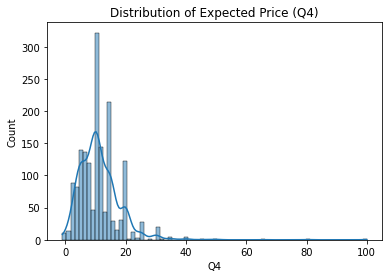

In [597]:
# Neural networks perform better when inputs are normalized and free of extreme outliers.
# Histograms/KDE Plots: Check if numerical features (Q2, Q4) are skewed or multimodal.
sns.histplot(data=df, x='Q4', kde=True)
plt.title('Distribution of Expected Price (Q4)')


Text(0.5, 1.0, 'Distribution of Expected Price (Q4)')

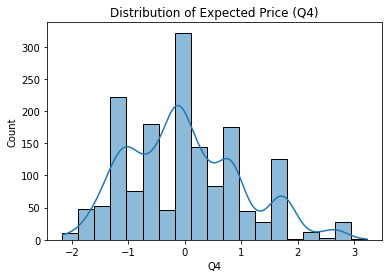

In [598]:
# Remove outliers from Q4 that are larger than 60
df = df[df['Q4'] < 30]

# Normalize Q4
df['Q4'] = (df['Q4'] - df['Q4'].mean()) / df['Q4'].std()

sns.histplot(data=df, x='Q4', kde=True)
plt.title('Distribution of Expected Price (Q4)')

Text(0.5, 1.0, 'Number of Ingredients (Q2) - Outlier Detection')

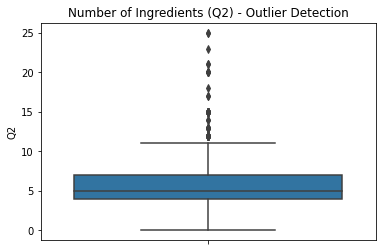

In [599]:
# Check outliers in Q2
sns.boxplot(data=df, y='Q2')
plt.title('Number of Ingredients (Q2) - Outlier Detection')

<Axes: ylabel='Q2'>

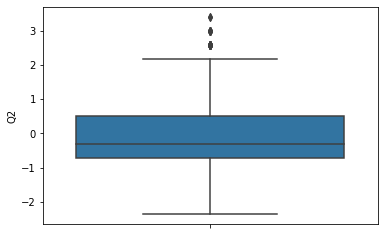

In [600]:
# Remove outliers from Q2 that are larger than 15
df = df[df['Q2'] < 15]

# Normalize Q2
df['Q2'] = (df['Q2'] - df['Q2'].mean()) / df['Q2'].std()

sns.boxplot(data=df, y='Q2')

In [601]:
df = encode_data(df)

# list the columns
# Print column names
print(df.columns.tolist())

print(len(df.columns))


['id', 'Q1', 'Q2', 'Q4', 'Label', '1001nights', '11sep', '13hours', '2012', '21jumpstreet', '30minutesorless', '3idiots', '47ronin', '7samurai', '9', 'actionmovie', 'airbud', 'aladdin', 'alien', 'alitathewarrior', 'americanpie', 'anchorman', 'angrybirds', 'anime', 'anjaanaanjaani', 'aquaman', 'aquietplace', 'arcane', 'argo', 'asilentvoice', 'avengers', 'babylon', 'backinaction', 'backtothefuture', 'badboys', 'bahen', 'barbie', 'batman', 'bighero6', 'billionstvshow', 'blackhawkdown', 'bladerunner', 'bollywood', 'borat', 'breakaway', 'breakingbad', 'bullettrain', 'burnt', 'captainamerica', 'carryon', 'cars', 'casablanca', 'chandnichowktochina', 'chef', 'chinesezodiac', 'cityhunter', 'cleopatra', 'cloudywithachanceofmeatballs', 'coco', 'comedy', 'coraline', 'crayonshinchan', 'crazyrichasians', 'crazystupidlove', 'dabba', 'dangal', 'deadpool', 'deadsilence', 'despicableme', 'diaryofawimpykid', 'dictator', 'diehard', 'djangounchained', 'doraemon', 'dotherightthing', 'dragon', 'drange', 'dri

### Model Building: Forward Pass

In [602]:
def relu(x):
    """ReLU activation function."""
    return np.maximum(0, x)

def relu_derivative(x):
    """Derivative of ReLU activation function."""
    return (x > 0).astype(float)

def softmax(z):
    """
    Compute the softmax of vector z, or row-wise for a matrix z.
    For numerical stability, subtract the maximum logit value from each
    row prior to exponentiation (see above).

    Parameters:
        `z` - a numpy array of shape (K,) or (N, K)

    Returns: a numpy array with the same shape as `z`, with the softmax
        activation applied to each row of `z`
    """
    exp_z= np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z/ np.sum(exp_z, axis=1, keepdims=True)

class FoodNeuralNetwork(object):
    def __init__(self, num_features=332, num_hidden=100, num_classes=128, lambda_reg=0.01):
        """
        Initialize the weights and biases of this two-layer MLP.
        """
        # Adding L2 regularization
        self.l2_lambda = lambda_reg

        # information about the model architecture
        self.num_features = num_features
        self.num_hidden = num_hidden
        self.num_classes = num_classes

        # weights and biases for the first layer of the MLP
        self.W1 = np.zeros([num_hidden, num_features])
        self.b1 = np.zeros([num_hidden])

        # weights and biases for the second layer of the MLP
        self.W2 = np.zeros([num_classes, num_hidden])
        self.b2 = np.zeros([num_classes])

        # initialize the weights and biases
        self.initializeParams()

        # set all values of intermediate variables (to be used in the
        # forward/backward passes) to None
        self.cleanup()


    def initializeParams(self):
        """
        Initialize the weights and biases of this two-layer MLP to be random.
        This random initialization is necessary to break the symmetry in the
        gradient descent update for our hidden weights and biases. If all our
        weights were initialized to the same value, then their gradients will
        all be the same!
        """
        self.W1 = np.random.normal(0, 2/self.num_features, self.W1.shape)
        self.b1 = np.random.normal(0, 2/self.num_features, self.b1.shape)
        self.W2 = np.random.normal(0, 2/self.num_hidden, self.W2.shape)
        self.b2 = np.random.normal(0, 2/self.num_hidden, self.b2.shape)

    def forward(self, X):
        """
        Compute the forward pass to produce prediction for inputs.

        Parameters:
            `X` - A numpy array of shape (N, self.num_features)

        Returns: A numpy array of predictions of shape (N, self.num_classes)
        """
        return do_forward_pass(self, X) # To be implemented below

    def backward(self, ts):
        """
        Compute the backward pass, given the ground-truth, one-hot targets.

        You may assume that the `forward()` method has been called for the
        corresponding input `X`, so that the quantities computed in the
        `forward()` method is accessible.

        Parameters:
            `ts` - A numpy array of shape (N, self.num_classes)
        """
        return do_backward_pass(self, ts) # To be implemented below

    def loss(self, ts):
        """
        Compute the average cross-entropy loss with L2 regularization
        
        Parameters:
            `ts` - A numpy array of shape (N, self.num_classes)
        """
        # Ensure no zero or negative values in log calculation
        # Add a small epsilon to prevent log(0)
        epsilon = 1e-15
        safe_y = np.clip(self.y, epsilon, 1 - epsilon)
        
        # Cross-entropy loss with safe logarithm
        cross_entropy_loss = np.sum(-ts * np.log(safe_y)) / ts.shape[0]
        
        # L2 regularization term
        l2_loss = (
            np.sum(self.W1 ** 2) + 
            np.sum(self.W2 ** 2)
        )
        
        # Combine cross-entropy loss with L2 regularization
        total_loss = cross_entropy_loss + 0.5 * self.l2_lambda * l2_loss
        
        return total_loss

    def update(self, alpha):
        """
        Compute the gradient descent update for the parameters of this model.

        Parameters:
            `alpha` - A number representing the learning rate
        """
        self.W1 = self.W1 - alpha * (self.W1_bar + self.l2_lambda * self.W1)
        self.b1 = self.b1 - alpha * self.b1_bar
        self.W2 = self.W2 - alpha * (self.W2_bar + self.l2_lambda * self.W2)
        self.b2 = self.b2 - alpha * self.b2_bar

    def cleanup(self):
        """
        Erase the values of the variables that we use in our computation.
        """
        self.N = None # Number of data points in the batch
        self.X = None # The input matrix
        self.m = None # Pre-activation value of the hidden state, should have shape
        self.h = None # Post-RELU value of the hidden state
        self.z = None # The logit scores (pre-activation output values)
        self.y = None # Class probabilities (post-activation)
        # To be filled in during the backward pass
        self.z_bar = None # The error signal for self.z2
        self.W2_bar = None # The error signal for self.W2
        self.b2_bar = None # The error signal for self.b2
        self.h_bar = None  # The error signal for self.h
        self.m_bar = None # The error signal for self.z1
        self.W1_bar = None # The error signal for self.W1
        self.b1_bar = None # The error signal for self.b1


    def predict(self, X):
        """
        Make class predictions for input X (outputs class indices).
        
        Parameters:
            X : numpy array of shape (N, num_features)
            
        Returns:
            numpy array of shape (N,) containing class indices (0, 1, or 2)
        """
        # Get class probabilities using existing forward pass
        proba = self.forward(X)  
        # Return index of maximum probability
        return np.argmax(proba, axis=1)  


def do_forward_pass(model, X):
    """
    Compute the forward pass to produce prediction for inputs.

    This function also keeps some of the intermediate values in
    the neural network computation, to make computing gradients easier.

    For the ReLU activation, you may find the function `np.maximum` helpful

    Parameters:
        `model` - An instance of the class MLPModel
        `X` - A numpy array of shape (N, model.num_features)

    Returns: A numpy array of predictions of shape (N, model.num_classes)
    """
    model.N = X.shape[0]
    model.X = X
    model.m = X.dot(model.W1.T) + model.b1 # the hidden state value (pre-activation)
    model.h = np.maximum(0, model.m) # the hidden state value (post ReLU activation)
    model.z = model.h.dot(model.W2.T) + model.b2  # the logit scores (pre-activation)
    model.y = softmax(model.z) # the class probabilities (post-activation)
    return model.y

def do_backward_pass(model, ts):
    """
    Compute the backward pass, given the ground-truth, one-hot targets.

    You may assume that `model.forward()` has been called for the
    corresponding input `X`, so that the quantities computed in the
    `forward()` method is accessible.

    The member variables you store here will be used in the `update()`
    method. Check that the shapes match what you wrote in Part 2.

    Parameters:
        `model` - An instance of the class MLPModel
        `ts` - A numpy array of shape (N, model.num_classes)
    """
    model.z_bar = (model.y - ts) / model.N
    model.W2_bar = model.z_bar.T.dot(model.h)
    model.b2_bar = np.sum(model.z_bar, axis=0)
    model.h_bar = model.z_bar.dot(model.W2)
    model.m_bar = model.h_bar * (model.m > 0)
    model.W1_bar = model.m_bar.T.dot(model.X)
    model.b1_bar = np.sum(model.m_bar, axis=0)

In [603]:
import numpy as np
import random
import matplotlib.pyplot as plt

def train_mbgd(model, X_train, t_train,
               alpha=0.1, n_epochs=0, batch_size=100,
               X_valid=None, t_valid=None,
               w_init=None, plot=True):
    '''
    Given `model` - an instance of MLPModel
          `X_train` - the data matrix to use for training
          `t_train` - the target vector to use for training
          `alpha` - the learning rate.
          `n_epochs` - the number of **epochs** of gradient descent to run
          `batch_size` - the size of each mini-batch
          `X_valid` - the data matrix to use for validation (optional)
          `t_valid` - the target vector to use for validation (optional)
          `w_init` - the initial `w` vector (if `None`, use a vector of all zeros)
          `plot` - whether to track statistics and plot the training curve

    Solves for model weights via mini-batch gradient descent.

    Returns the final weights after training.
    '''

    def make_onehot(indices, total=128):
        I = np.eye(total)
        return I[indices]

    # Initialize weights
    if w_init is not None:
        w = w_init
    else:
        w = np.zeros(X_train.shape[1])

    train_loss = []  # Track loss per batch
    valid_loss = []  # Track validation loss per epoch
    niter = 0  # Count iterations

    N = X_train.shape[0]  # Number of training samples
    indices = list(range(N))

    try:
        for epoch in range(n_epochs):
            random.shuffle(indices)  # Shuffle data each epoch

            for i in range(0, N, batch_size):
                indices_in_batch = indices[i: min(i + batch_size, N)]  # Handle last batch
                X_minibatch = X_train[indices_in_batch, :]
                t_minibatch = make_onehot(t_train[indices_in_batch], model.num_classes)

                # Forward & Backward pass
                model.cleanup()
                model.forward(X_minibatch)
                model.backward(t_minibatch)

                # Update weights using average gradient over mini-batch
                model.update(alpha / batch_size)

                if plot:
                    train_loss.append(model.loss(t_minibatch))  # Log batch loss
                niter += 1

            # Compute validation loss once per epoch
            if plot and (X_valid is not None) and (t_valid is not None):
                model.cleanup()
                model.forward(X_valid)
                valid_loss.append((niter, model.loss(make_onehot(t_valid, model.num_classes))))
    
    except Exception as e:
        print(f"Training interrupted: {e}")

    # Plot the loss curves
    if plot:
        plt.title("Mini-Batch Gradient Descent Training Curve")
        plt.plot(train_loss, label="Training Loss")
        if valid_loss:
            plt.plot([iter for (iter, loss) in valid_loss],
                     [loss for (iter, loss) in valid_loss],
                     label="Validation Loss")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        print("Final Training Loss:", train_loss[-1])
        if valid_loss:
            print("Final Validation Loss:", valid_loss[-1])

    # return model.weights  # Return final weights


def train_sgd(model, X_train, t_train,
              alpha=0.1, n_epochs=0, batch_size=100,
              X_valid=None, t_valid=None,
              w_init=None, plot=True):
    '''
    Given model - an instance of MLPModel
          X_train - the data matrix to use for training
          t_train - the target vector to use for training
          alpha - the learning rate.
                    From our experiments, it appears that a larger learning rate
                    is appropriate for this task.
          n_epochs - the number of **epochs** of gradient descent to run
          batch_size - the size of each mini batch
          X_valid - the data matrix to use for validation (optional)
          t_valid - the target vector to use for validation (optional)
          w_init - the initial w vector (if None, use a vector of all zeros)
          plot - whether to track statistics and plot the training curve

    Solves for model weights via stochastic gradient descent,
    using the provided batch_size.

    Return weights after niter iterations.
    '''
    def make_onehot(indicies, total=128):
        I = np.eye(total)
        return I[indicies]
    # as before, initialize all the weights to zeros
    w = np.zeros(X_train.shape[1])

    train_loss = [] # for the current minibatch, tracked once per iteration
    valid_loss = [] # for the entire validation data set, tracked once per epoch

    # track the number of iterations
    niter = 0

    # we will use these indices to help shuffle X_train
    N = X_train.shape[0] # number of training data points
    indices = list(range(N))
    try:
        for e in range(n_epochs):
            random.shuffle(indices) # for creating new minibatches

            for i in range(0, N, batch_size):
                if (i + batch_size) > N:
                    # At the very end of an epoch, if there are not enough
                    # data points to form an entire batch, then skip this batch
                    continue

                indices_in_batch = indices[i: i+batch_size]
                X_minibatch = X_train[indices_in_batch, :]
                t_minibatch = make_onehot(t_train[indices_in_batch], model.num_classes)

                # gradient descent iteration
                model.cleanup()
                model.forward(X_minibatch)
                model.backward(t_minibatch)
                model.update(alpha)

                if plot:
                    # Record the current training loss values
                    train_loss.append(model.loss(t_minibatch))
                niter += 1

            # compute validation data metrics, if provided, once per epoch
            if plot and (X_valid is not None) and (t_valid is not None):
                model.cleanup()
                model.forward(X_valid)
                valid_loss.append((niter, model.loss(make_onehot(t_valid, model.num_classes))))
     
    except Exception as e:
        print(f"Training interrupted: {e}")
    if plot:
        plt.title("SGD Training Curve Showing Loss at each Iteration")
        plt.plot(train_loss, label="Training Loss")
        if (X_valid is not None) and (t_valid is not None): # compute validation data metrics, if provided
            plt.plot([iter for (iter, loss) in valid_loss],
                     [loss for (iter, loss) in valid_loss],
                     label="Validation Loss")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        print("Final Training Loss:", train_loss[-1])
        if (X_valid is not None) and (t_valid is not None):
            print("Final Validation Loss:", valid_loss[-1])

In [604]:
def train_test_split(X, y, test_size=0.2, random_state=None):
    """
    Split data into training and testing sets.

    Parameters:
        X (numpy.ndarray): Feature matrix.
        y (numpy.ndarray): Labels array.
        test_size (float): Proportion of the dataset to include in the test split (default 0.2).
        random_state (int): Seed for reproducibility (default None).

    Returns:
        X_train, X_test, y_train, y_test: Split datasets.
    """
    if random_state is not None:
        np.random.seed(random_state)  # Set random seed for reproducibility

    # Shuffle the data
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    # Apply the shuffled indices to X and y
    X = X[indices]
    y = y[indices]

    # Compute the split index
    split_idx = int(X.shape[0] * (1 - test_size))

    # Split the data
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    X_train = X_train.astype(int)
    X_test = X_test.astype(int)

    return X_train, X_test, y_train, y_test

Training interrupted: arrays used as indices must be of integer (or boolean) type


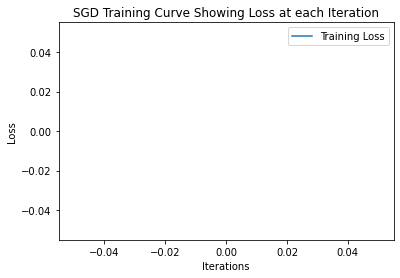

IndexError: list index out of range

In [605]:
feature_columns = ['Q1', 'Q2', 'Q4', '1001nights', '11sep', '13hours', '2012', '21jumpstreet', '30minutesorless', '3idiots', '47ronin', '7samurai', '9', 'actionmovie', 'airbud', 'aladdin', 'alien', 'alitathewarrior', 'americanpie', 'anchorman', 'angrybirds', 'anime', 'anjaanaanjaani', 'aquaman', 'aquietplace', 'arcane', 'argo', 'asilentvoice', 'avengers', 'babylon', 'backinaction', 'backtothefuture', 'badboys', 'bahen', 'barbie', 'batman', 'bighero6', 'billionstvshow', 'blackhawkdown', 'bladerunner', 'bollywood', 'borat', 'breakaway', 'breakingbad', 'bullettrain', 'burnt', 'captainamerica', 'carryon', 'cars', 'casablanca', 'chandnichowktochina', 'chef', 'chinesezodiac', 'cityhunter', 'cleopatra', 'cloudywithachanceofmeatballs', 'coco', 'comedy', 'coraline', 'crayonshinchan', 'crazyrichasians', 'crazystupidlove', 'dabba', 'dangal', 'deadpool', 'deadsilence', 'despicableme', 'diaryofawimpykid', 'dictator', 'diehard', 'djangounchained', 'doraemon', 'dotherightthing', 'dragon', 'drange', 'drishyam', 'drive', 'dune', 'eastsidesushi', 'eatpraylove', 'emojimovie', 'eternalsunshineofthespotlessmind', 'evangelion', 'everythingeverywhereallatonce', 'fallenangels', 'fastandfurious', 'ferrisbuellersdayoff', 'fightclub', 'findingnemo', 'fivenightsatfreddys', 'foodwars', 'freeguy', 'friday', 'friends', 'frozen', 'futurama', 'garfield', 'gijoe', 'girlstrip', 'gladiator', 'godfather', 'godzilla', 'gonegirl', 'goodfellas', 'goodwillhunting', 'gossipgirl', 'granturismo', 'greenbook', 'grownups', 'haikyu', 'hangover', 'happygilmore', 'haroldandkumar', 'harrypoter', 'harrypotter', 'hawkeye', 'heretic', 'highschoolmusical', 'hitman', 'homealone', 'horror', 'housemd', 'howlsmovingcastle', 'howtoloseaguyin10days', 'hunger', 'idk', 'idontknow', 'inception', 'indianajones', 'insideout', 'interstellar', 'ipman', 'ironman', 'isleofdogs', 'italianjon', 'jamesbond', 'jaws', 'jirodreamsofsush', 'johnnyenglish', 'johnwick', 'jurassicpark', 'karatekid', 'khabikhushikhabigham', 'kikisdeliveryservice', 'killbill', 'kingdomofheaven', 'kingkong', 'koenokatachi', 'kungfupanda', 'lalaland', 'lastsamurai', 'lawrenceofarabia', 'lifeisbeautiful', 'lifeofpi', 'lionking', 'liquoricepizza', 'lordoftherings', 'lostintranslation', 'lovehard', 'luca', 'lucy', 'madagascar', 'madeinabyssdawnofthedeepsoul', 'madmax', 'mammamia', 'mandoob', 'maninblack', 'mariomovie', 'mazerunner', 'meangirls', 'meitanteikonan', 'memoirsofageisha', 'memoryofageisha', 'meninblack', 'middleeasternmovie', 'middleeastmovie', 'midnightdiner', 'midnightdinner', 'minions', 'moneyball', 'monster', 'montypython', 'mrdeeds', 'mulan', 'murderontheorientexpress', 'mycousinvinny', 'myheroacademia', 'myneighbourtotoro', 'mysticpizza', 'na', 'neverendingstory', 'no', 'oldboy', 'onepiece', 'oppenheimer', 'pacificrim', 'parasite', 'passengers2016', 'pearlharbour', 'piratesofthecaribbean', 'piratesofthecarribeans', 'pizza', 'pokemon', 'ponyo', 'princeofegypt', 'princessdiaries', 'probablysomemiddleeatmovies', 'probablysomethingwithamiddleeasternsetting', 'pulpfiction', 'pursuitofhappyness', 'ratatouille', 'ratatoullie', 'rickandmorty', 'romancemovie', 'romanticmovies', 'runningman', 'rurounikenshin', 'rushhour', 'samuraijack', 'savingprivateryan', 'scarymovie', 'scifi', 'scoobydoo', 'scottpilgrim', 'setitup', 'sevensamurai', 'shangchi', 'sharktale', 'shawarmalegend', 'shawshankredemption', 'shazam', 'shogun', 'shortmoviebecauseieatitfast', 'shrek', 'someghiblimovie', 'sonicthehedgehog', 'soul', 'southpark', 'spacejam', 'spiderman', 'spiritedaway', 'spongebob', 'spykids', 'squidgame', 'starwars', 'stepbrothers', 'strangerthings', 'suits', 'superbad', 'suzume', 'talented', 'thebiglebowski', 'thebigshort', 'thebigsick', 'theboyandtheheron', 'theboys', 'thebreakfastclub', 'thedavincicode', 'thedoramovie', 'thegentlemen', 'thegoofymovie', 'thegrinch', 'theintern', 'theinvisibleguest', 'theitalianjob', 'thekiterunner', 'thelegomovie', 'thelittlemermaid', 'themeg', 'themenu', 'themummy', 'thepacific', 'theperfectstorm', 'theproposal', 'theritual', 'theroom', 'thesamurai', 'thesocialnetwork', 'thespynextdoor', 'thetrumanshow', 'thewhale', 'thisistheend', 'thosecommercialsbythetorontofoodmanzabebsiisthebest', 'threeidiots', 'timeofhappiness', 'titanic', 'tokyostory', 'totoro', 'toystory', 'traintobusan', 'transformer', 'turningred', 'ultramanrising', 'unclegrandpa', 'unknown', 'us', 'wags', 'walle', 'waynesworld', 'weatheringwithyou', 'whiplash', 'whoamijackiechan', 'wicked', 'wolfofwallstreet', 'wolverine', 'yakuza', 'yehjawaanihaideewani', 'youdontmesswiththezohan', 'zootopia', 'Week day lunch', 'Week day dinner', 'Weekend lunch', 'Weekend dinner', 'At a party', 'Late night snack', 'soda', 'other', 'tea', 'alcohol', 'water', 'soup', 'juice', 'milk', 'smoothie', 'asian alcohol', 'asian pop', 'milkshake', 'Parents', 'Siblings', 'Friends', 'Teachers', 'Strangers']

# summarize df
features = df[feature_columns].values
target = df['Label'].values

# create a small subset of the data for testing
X = features[:1000]
y = target[:1000]
model = FoodNeuralNetwork(num_features=X.shape[1], num_hidden=256, num_classes=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_sgd(model, X_train=X_train, t_train=y_train, alpha=0.01, batch_size=16, n_epochs=100)

In [ ]:
X = df[feature_columns].fillna(0).values
y = df['Label'].map({'Pizza': 0, 'Shawarma': 1, 'Sushi': 2}).values  # Convert labels to integers

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

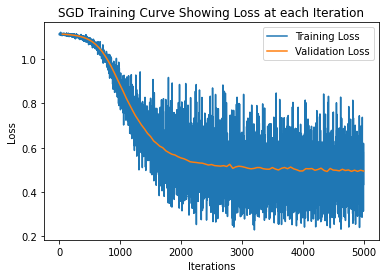

Final Training Loss: 0.433808299329073
Final Validation Loss: (5000, 0.49438306454413433)


In [ ]:
model = FoodNeuralNetwork(num_features=332, num_hidden=256, num_classes=3)

train_sgd(model, X_train, y_train, alpha=0.01, n_epochs=100, batch_size=25, X_valid=X_test, t_valid=y_test)

In [ ]:
print("X_test shape:", X_test.shape)  # Should be (samples, 332)
print("Model's expected features:", model.num_features)  # Should be 332

X_test shape: (314, 332)
Model's expected features: 332


In [ ]:
from sklearn.metrics import accuracy_score

def evaluate_model(model, X_test, y_test):
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# Usage
test_accuracy = evaluate_model(model, X_test, y_test)
print(f"\nFinal Test Accuracy: {test_accuracy:.2%}")


Final Test Accuracy: 84.39%


In [ ]:
model.predict(X_test)

array([1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 0, 0, 2, 1, 2, 0, 0, 0, 1, 1, 2, 2,
       0, 2, 2, 2, 1, 1, 2, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2, 2, 0, 1, 2,
       0, 2, 2, 0, 0, 1, 1, 2, 0, 2, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 2,
       0, 1, 2, 0, 2, 0, 1, 2, 2, 1, 0, 0, 2, 2, 1, 2, 1, 0, 2, 2, 2, 0,
       1, 1, 2, 1, 0, 1, 0, 0, 1, 1, 2, 1, 0, 1, 0, 0, 1, 2, 2, 1, 1, 2,
       2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 0, 0, 2,
       2, 0, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 0, 2, 1, 2, 2, 2, 1, 1, 1, 2,
       1, 2, 2, 0, 2, 2, 0, 1, 2, 2, 1, 0, 0, 1, 0, 2, 2, 0, 1, 0, 2, 1,
       1, 2, 2, 0, 0, 2, 2, 0, 1, 2, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 2, 1, 1, 2, 1, 0, 2, 0, 0, 1, 2, 2, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 2, 1, 2, 0, 1, 1, 0, 0, 0, 1, 0, 1, 2, 2, 1, 1, 2, 1, 2,
       0, 0, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 0, 1, 0, 1, 2, 1, 2, 0, 0, 0,
       2, 2, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 2, 1, 0, 0, 2, 1, 0, 2, 0, 0, 1, 0,